In [1]:
import pandas as pd

clinical_df = pd.read_csv('./data/clinical.csv')
radiomic_16_df = pd.read_csv('./data/radiomics_16bins.csv')
radiomic_48_df = pd.read_csv('./data/radiomics_48bins.csv')


In [2]:
print(f'Clinical: {clinical_df.shape}')
print(f'Radiomic 16: {radiomic_16_df.shape}')
print(f'Radiomic 48: {radiomic_48_df.shape}')

Clinical: (422, 10)
Radiomic 16: (416, 163)
Radiomic 48: (416, 163)


In [3]:
clinical_df.columns

Index(['PatientID', 'age', 'clinical.T.Stage', 'Clinical.N.Stage',
       'Clinical.M.Stage', 'Overall.Stage', 'Histology', 'gender',
       'Survival.time', 'deadstatus.event'],
      dtype='object')

In [4]:
radiomic_16_df.columns

Index(['pat_id', 'mask_id', 'morph_volume', 'morph_vol_approx',
       'morph_area_mesh', 'morph_av', 'morph_comp_1', 'morph_comp_2',
       'morph_sph_dispr', 'morph_sphericity',
       ...
       'ngl_hdhge_3D', 'ngl_glnu_3D', 'ngl_glnu_norm_3D', 'ngl_dcnu_3D',
       'ngl_dcnu_norm_3D', 'ngl_dc_perc_3D', 'ngl_gl_var_3D', 'ngl_dc_var_3D',
       'ngl_dc_entr_3D', 'ngl_dc_energy_3D'],
      dtype='object', length=163)

In [5]:
radiomic_48_df.columns

Index(['pat_id', 'mask_id', 'morph_volume', 'morph_vol_approx',
       'morph_area_mesh', 'morph_av', 'morph_comp_1', 'morph_comp_2',
       'morph_sph_dispr', 'morph_sphericity',
       ...
       'ngl_hdhge_3D', 'ngl_glnu_3D', 'ngl_glnu_norm_3D', 'ngl_dcnu_3D',
       'ngl_dcnu_norm_3D', 'ngl_dc_perc_3D', 'ngl_gl_var_3D', 'ngl_dc_var_3D',
       'ngl_dc_entr_3D', 'ngl_dc_energy_3D'],
      dtype='object', length=163)

In [6]:
# find patients in clinical_df not in radiomic_16_df
clinical_patients = set(clinical_df['PatientID'])
radiomic_16_patients = set(radiomic_16_df['pat_id'])
missing_in_16 = clinical_patients - radiomic_16_patients
print(f'Patients in clinical_df not in radiomic_16_df: {missing_in_16}')

Patients in clinical_df not in radiomic_16_df: {'LUNG1-021', 'LUNG1-246', 'LUNG1-085', 'LUNG1-128', 'LUNG1-014', 'LUNG1-194'}


In [7]:
# Inner join clinical_df and radiomic_16_df on PatientID and pat_id
merged_16_df = pd.merge(clinical_df, radiomic_16_df, left_on='PatientID', right_on='pat_id', how='inner')
print(f'Merged 16: {merged_16_df.shape}')

Merged 16: (416, 173)


In [8]:
# Create feature survival_rate_18m
merged_16_df['survival_rate_18m'] = (merged_16_df['deadstatus.event'] == 1) & (merged_16_df['Survival.time'] >= 540)

## Train/Test/Split

In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(merged_16_df, test_size=0.2, random_state=42, stratify=merged_16_df['survival_rate_18m'])
print(f'Train: {train_df.shape}, Test: {test_df.shape}')

Train: (332, 174), Test: (84, 174)


## Dimensionality Reduction

### Correlation Analysis

In [10]:
import numpy as np

numbers_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numbers_df.corr().mean().abs().sum(axis=0)
print(corr_matrix)

6.685331449579167


#### Plot correlation matrix higher than 0.8

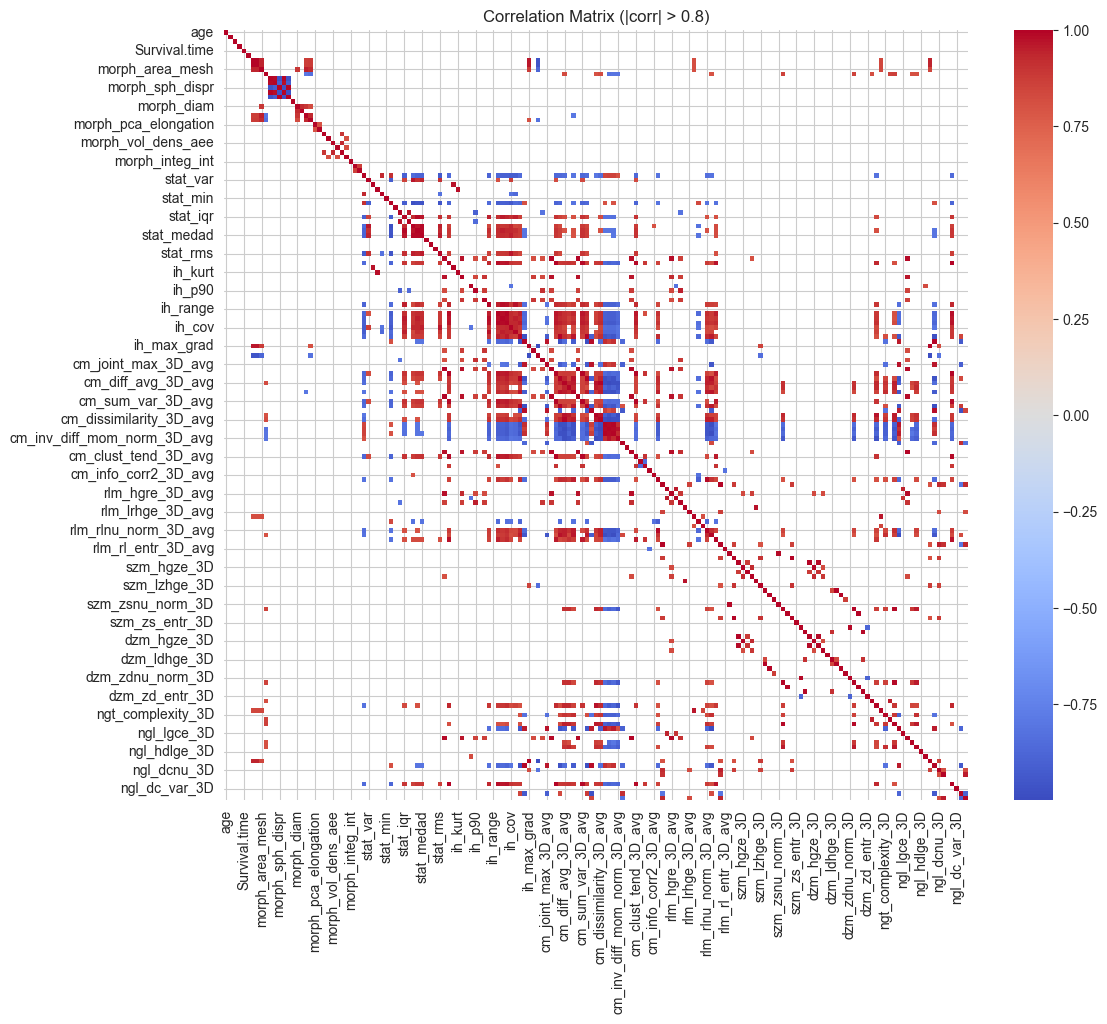

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = numbers_df.corr()
corr_matrix_filtered = corr_matrix[corr_matrix.abs() > 0.8]
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_filtered, annot=False, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix (|corr| > 0.8)')
plt.show()

### Info

In [12]:
train_df.describe()

,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Survival.time,deadstatus.event,morph_volume,morph_vol_approx,morph_area_mesh,morph_av,...,ngl_hdhge_3D,ngl_glnu_3D,ngl_glnu_norm_3D,ngl_dcnu_3D,ngl_dcnu_norm_3D,ngl_dc_perc_3D,ngl_gl_var_3D,ngl_dc_var_3D,ngl_dc_entr_3D,ngl_dc_energy_3D
count,313.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,...,332.000000,332.000000,332.000000,332.000000,332.000000,332.0,332.000000,332.000000,332.000000,332.000000
mean,68.065705,2.466867,1.388554,0.030120,995.259036,0.885542,74649.982956,74715.639678,13043.278045,0.298933,...,37435.061681,38466.649575,0.320962,11396.332586,0.089051,1.0,6.357903,51.704364,6.048901,0.055475
std,10.300771,1.148538,1.215306,0.289279,1027.039640,0.318847,97567.704922,97591.156754,12045.596813,0.153813,...,21398.266382,66377.355675,0.189421,35224.346924,0.086844,0.0,5.324985,18.485016,1.027756,0.094730
min,33.684900,1.000000,0.000000,0.000000,10.000000,0.000000,477.069989,488.944352,401.868933,0.075282,...,1957.053917,42.180952,0.067706,74.533861,0.038118,1.0,0.145457,4.111107,2.043137,0.006929
25%,60.728300,2.000000,0.000000,0.000000,248.250000,1.000000,8856.441127,8888.309821,3262.979496,0.185130,...,20403.082988,1604.130155,0.155854,602.849557,0.044342,1.0,2.042243,41.279407,5.710628,0.012036
50%,68.747400,2.000000,2.000000,0.000000,556.500000,1.000000,38286.535225,38357.917219,9015.270244,0.260825,...,34861.334032,12585.523126,0.293238,1945.847620,0.058455,1.0,4.779150,53.061011,6.345159,0.019263
75%,76.293000,4.000000,2.000000,0.000000,1517.750000,1.000000,111798.862539,111909.816042,20165.635673,0.354682,...,50963.501061,49554.225226,0.436733,7448.714372,0.086611,1.0,9.890210,64.639879,6.737462,0.045952
max,91.704300,5.000000,4.000000,3.000000,4454.000000,1.000000,662404.655789,662441.365421,55556.140701,0.842369,...,120636.959510,550564.857018,0.897567,393353.641220,0.580729,1.0,26.528016,96.363475,7.487067,0.577315


#### Columns with strings

In [13]:
string_cols = train_df.select_dtypes(include=['object']).columns
print(f'String columns: {string_cols.tolist()}')

String columns: ['PatientID', 'Overall.Stage', 'Histology', 'gender', 'pat_id', 'mask_id']


In [14]:
train_df[string_cols].nunique()

PatientID        332
Overall.Stage      4
Histology          4
gender             2
pat_id           332
mask_id            1
dtype: int64

In [15]:
train_df.select_dtypes(include=['bool']).columns

Index(['survival_rate_18m'], dtype='object')

### Drop columns

In [16]:
train_df = train_df.drop(columns=['PatientID', 'Overall.Stage', 'Histology', 'gender', 'pat_id', 'mask_id', 'age'])

In [17]:
train_df.isnull().sum().sort_values(ascending=False)

clinical.T.Stage     0
Clinical.N.Stage     0
Clinical.M.Stage     0
Survival.time        0
deadstatus.event     0
                    ..
ngl_gl_var_3D        0
ngl_dc_var_3D        0
ngl_dc_entr_3D       0
ngl_dc_energy_3D     0
survival_rate_18m    0
Length: 167, dtype: int64

### PCA

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_result = pca.fit_transform(train_df)



In [19]:
print(f'Original shape: {train_df.shape}')
print(f'PCA reduced shape: {pca_result.shape}')

Original shape: (332, 167)
PCA reduced shape: (332, 20)


## Explorative data analysis

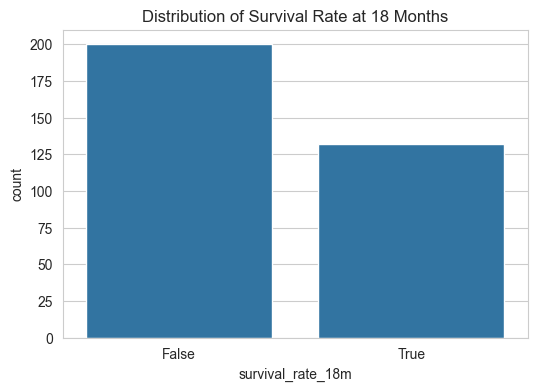

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of survival_rate_18m
plt.figure(figsize=(6, 4))
sns.countplot(x='survival_rate_18m', data=train_df)
plt.title('Distribution of Survival Rate at 18 Months')
plt.show()

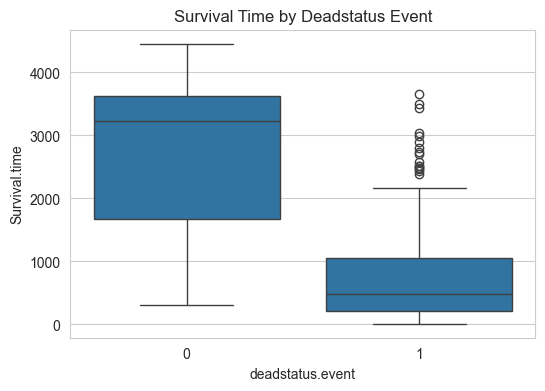

In [21]:
# Survival time and deadstatus.event relationship
plt.figure(figsize=(6, 4))
sns.boxplot(x='deadstatus.event', y='Survival.time', data=train_df)
plt.title('Survival Time by Deadstatus Event')
plt.show()

In [22]:
train_df = train_df.drop(columns=['deadstatus.event', 'Survival.time'])

## Univariate Analysis

                feature      auc  p_value  n_pos  n_neg
   rlm_rlnu_norm_3D_avg 0.604508 0.001269    132    200
         rlm_sre_3D_avg 0.604091 0.001327    132    200
             ih_entropy 0.601932 0.001670    132    200
     cm_diff_avg_3D_avg 0.601250 0.001794    132    200
cm_dissimilarity_3D_avg 0.601250 0.001794    132    200
   cm_joint_entr_3D_avg 0.601098 0.001823    132    200
     cm_sum_entr_3D_avg 0.600795 0.001881    132    200
               ih_medad 0.600644 0.001911    132    200
    cm_diff_entr_3D_avg 0.600227 0.001996    132    200
        ngt_contrast_3D 0.599432 0.002167    132    200


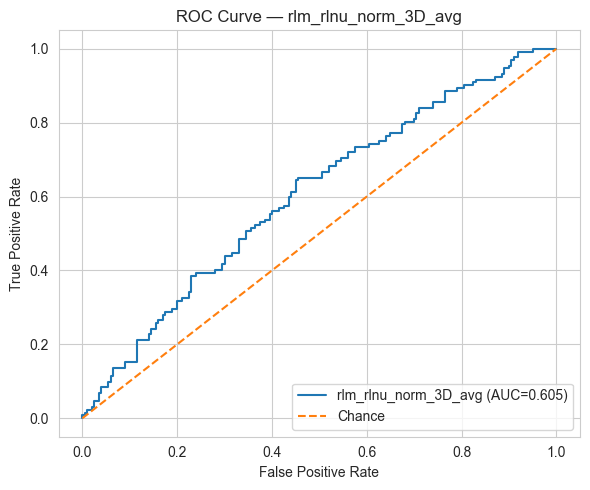

In [23]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_curve, auc as sk_auc
import matplotlib.pyplot as plt

df = train_df.copy()
y = df['survival_rate_18m'].astype(int)
X = df.drop(columns=['survival_rate_18m'], errors='ignore')

rows = []
for col in X.columns:
    s = X[col]
    mask = s.notna()
    s, yy = s[mask].values, y[mask].values
    pos, neg = s[yy == 1], s[yy == 0]
    if len(pos) == 0 or len(neg) == 0:
        continue
    U1 = mannwhitneyu(pos, neg, alternative='greater', method='auto').statistic
    p_two = mannwhitneyu(pos, neg, alternative='two-sided', method='auto').pvalue

    auc = U1 / (len(pos) * len(neg))
    rows.append((col, auc, p_two, len(pos), len(neg)))

results_df = (pd.DataFrame(rows, columns=['feature','auc','p_value','n_pos','n_neg'])
              .sort_values(['auc','p_value'], ascending=[False, True]))
print(results_df.head(10)[['feature','auc','p_value','n_pos','n_neg']].to_string(index=False))

best_feat = results_df.iloc[0]['feature']
scores = X[best_feat]
m = scores.notna()
fpr, tpr, _ = roc_curve(y[m], scores[m])
roc_auc = sk_auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'{best_feat} (AUC={roc_auc:.3f})')
plt.plot([0,1], [0,1], '--', label='Chance')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve — {best_feat}')
plt.legend(loc='lower right'); plt.tight_layout()
plt.show()


## Make Preprocessing Pipeline

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA


preprocessing_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=10)),
])

train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df['survival_rate_18m'])

X_train = train_df.drop(columns=['survival_rate_18m'], errors='ignore')
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
y_train = train_df['survival_rate_18m'].astype(int)

x_val = val_df.drop(columns=['survival_rate_18m'], errors='ignore')
X_val_processed = preprocessing_pipeline.transform(x_val)
y_val = val_df['survival_rate_18m'].astype(int)

testing_df = test_df.drop(columns=['survival_rate_18m', 'deadstatus.event', 'Survival.time', 'PatientID', 'Overall.Stage', 'Histology', 'gender', 'pat_id', 'mask_id', 'age'], errors='ignore')
X_test_processed = preprocessing_pipeline.transform(testing_df)
y_test = test_df['survival_rate_18m'].astype(int)

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgboost_model = XGBClassifier(n_estimators=5, max_depth=3, learning_rate=0.05, reg_lambda=4, objective='binary:hinge')
xgboost_model.fit(X_train_processed, y_train)


y_train_proba = xgboost_model.predict_proba(X_train_processed)[:, 1]
train_auc = roc_auc_score(y_train, y_train_proba)
print(f"Train ROC AUC: {train_auc:.3f}")

y_val_proba = xgboost_model.predict_proba(X_val_processed)[:, 1]
val_auc = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC AUC: {val_auc:.3f}")


Train ROC AUC: 0.647
Validation ROC AUC: 0.483


## SVM

In [26]:
from sklearn.svm import SVC

svm_model = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_processed, y_train)

y_train_proba_svm = svm_model.predict_proba(X_train_processed)[:, 1]
train_auc_svm = roc_auc_score(y_train, y_train_proba_svm)

y_val_proba_svm = svm_model.predict_proba(X_val_processed)[:, 1]
val_auc_svm = roc_auc_score(y_val, y_val_proba_svm)

print(f"SVM Train ROC AUC: {train_auc_svm:.3f}")
print(f"SVM Validation ROC AUC: {val_auc_svm:.3f}")


SVM Train ROC AUC: 0.305
SVM Validation ROC AUC: 0.527


## MLP

In [27]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(30, 30), activation='relu', alpha=5, solver='adam', max_iter=80, random_state=42)
mlp_model.fit(X_train_processed, y_train)

y_train_proba_mlp = mlp_model.predict_proba(X_train_processed)[:, 1]
train_auc_mlp = roc_auc_score(y_train, y_train_proba_mlp)

y_val_proba_mlp = mlp_model.predict_proba(X_val_processed)[:, 1]
val_auc_mlp = roc_auc_score(y_val, y_val_proba_mlp)

print(f"MLP Train ROC AUC: {train_auc_mlp:.3f}")
print(f"MLP Validation ROC AUC: {val_auc_mlp:.3f}")

MLP Train ROC AUC: 0.723
MLP Validation ROC AUC: 0.470


C:\Users\denis\AppData\Local\pypoetry\Cache\virtualenvs\digitalbiomarkers-joSPpl4n-py3.12\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


## KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train_processed, y_train)
y_train_proba_knn = knn_model.predict_proba(X_train_processed)[:, 1]
train_auc_knn = roc_auc_score(y_train, y_train_proba_knn)

y_val_proba_knn = knn_model.predict_proba(X_val_processed)[:, 1]
val_auc_knn = roc_auc_score(y_val, y_val_proba_knn)

print(f"KNN Train ROC AUC: {train_auc_knn:.3f}")
print(f"KNN Validation ROC AUC: {val_auc_knn:.3f}")

KNN Train ROC AUC: 0.685
KNN Validation ROC AUC: 0.495


## Explain feature importance

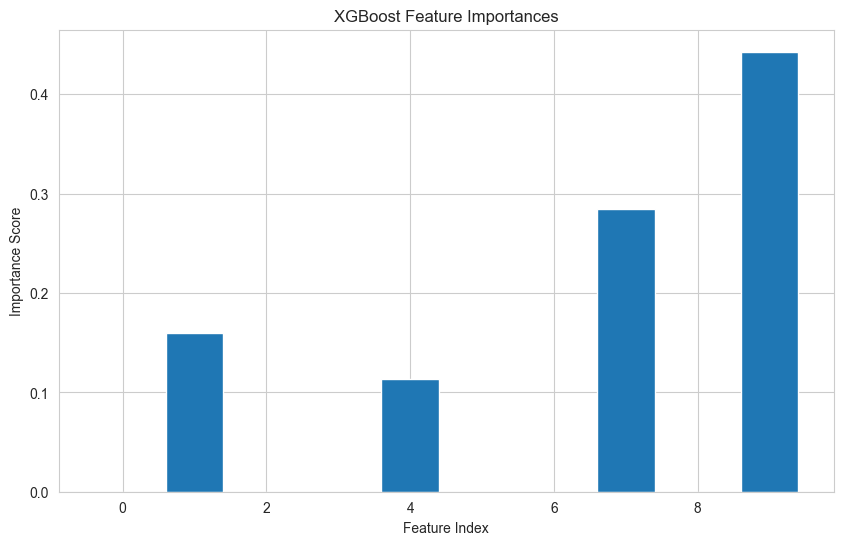

In [29]:
import matplotlib.pyplot as plt

feature_importances = xgboost_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title('XGBoost Feature Importances')
plt.show()

## Testing

In [30]:
y_test_proba_xgboost = xgboost_model.predict_proba(X_test_processed)[:, 1]
test_auc_xgboost = roc_auc_score(y_test, y_test_proba_xgboost)
print(f"XGB Test ROC AUC: {test_auc_xgboost:.3f}")

y_test_proba_svm = svm_model.predict_proba(X_test_processed)[:, 1]
test_auc_svm = roc_auc_score(y_test, y_test_proba_svm)
print(f"SVM Test ROC AUC: {test_auc_svm:.3f}")

y_test_proba_mlp = mlp_model.predict_proba(X_test_processed)[:, 1]
test_auc_mlp = roc_auc_score(y_test, y_test_proba_mlp)
print(f"MLP Test ROC AUC: {test_auc_mlp:.3f}")

y_test_proba_knn = knn_model.predict_proba(X_test_processed)[:, 1]
test_auc_knn = roc_auc_score(y_test, y_test_proba_knn)
print(f"KNN Test ROC AUC: {test_auc_knn:.3f}")

XGB Test ROC AUC: 0.528
SVM Test ROC AUC: 0.354
MLP Test ROC AUC: 0.655
KNN Test ROC AUC: 0.615
